In [ ]:
import numpy as np
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import get_critical_contacts
from src.gmm import *
from src.contact_space import *

## GMM analysis

In [14]:
def extract_principal_component_from_covariance(covariance_matrix, component_idx=0):
    """
    从协方差矩阵中提取主成分特征向量
    
    Args:
        covariance_matrix: 协方差矩阵 Σ (n_features, n_features)
        component_idx: 主成分索引，0表示第一主成分PC1
        
    Returns:
        eigenvalue: 对应的特征值（方差大小）
        eigenvector: 单位特征向量（主成分方向）
        explained_variance_ratio: 该主成分解释的方差比例
    """
    # 特征分解
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # 按特征值降序排序
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 提取指定主成分
    target_eigenvalue = eigenvalues[component_idx]
    target_eigenvector = eigenvectors[:, component_idx]
    
    # 确保是单位向量
    target_eigenvector = target_eigenvector / np.linalg.norm(target_eigenvector)
    
    # 计算解释方差比例
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = target_eigenvalue / total_variance
    
    print(f"第{component_idx+1}主成分分析结果:")
    print(f"  特征值: {target_eigenvalue:.6f}")
    print(f"  特征向量模长: {np.linalg.norm(target_eigenvector):.6f}")
    print(f"  解释方差比例: {explained_variance_ratio:.4f} ({explained_variance_ratio*100:.2f}%)")
    
    return target_eigenvalue, target_eigenvector, explained_variance_ratio


def analyze_covariance_pca(covariance_matrix, top_k=5):
    """
    完整分析协方差矩阵的主成分
    """
    print("=== 协方差矩阵主成分分析 ===")
    print(f"协方差矩阵形状: {covariance_matrix.shape}")
    print(f"协方差矩阵行列式: {np.linalg.det(covariance_matrix):.6e}")
    print(f"协方差矩阵迹: {np.trace(covariance_matrix):.6f}")
    
    # 特征分解
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # 降序排序
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 计算累积解释方差
    total_variance = np.sum(eigenvalues)
    explained_variance_ratios = eigenvalues / total_variance
    cumulative_variance = np.cumsum(explained_variance_ratios)
    
    print(f"\n前{top_k}个主成分:")
    print("PC\t特征值\t\t解释方差\t累积方差")
    print("-" * 50)
    for i in range(min(top_k, len(eigenvalues))):
        print(f"{i+1}\t{eigenvalues[i]:.6f}\t{explained_variance_ratios[i]:.4f}\t\t{cumulative_variance[i]:.4f}")
    
    return eigenvalues, eigenvectors, explained_variance_ratios


def visualize_principal_components(eigenvalues, explained_variance_ratios, top_k=10):
    """
    可视化主成分分析结果
    """
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 特征值scree plot
    n_components = min(top_k, len(eigenvalues))
    ax1.plot(range(1, n_components+1), eigenvalues[:n_components], 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('principal component index')
    ax1.set_ylabel('eigenvalue')
    ax1.set_title('Scree Plot - eigenvalue distribution')
    ax1.grid(True, alpha=0.3)
    
    # 解释方差比例
    ax2.bar(range(1, n_components+1), explained_variance_ratios[:n_components], 
            alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('principal component index')
    ax2.set_ylabel('explained variance ratio')
    ax2.set_title('explained variance ratio distribution')
    ax2.grid(True, alpha=0.3)
    
    # 添加累积方差线
    ax2_twin = ax2.twinx()
    cumulative_variance = np.cumsum(explained_variance_ratios[:n_components])
    ax2_twin.plot(range(1, n_components+1), cumulative_variance, 'ro-', 
                  linewidth=2, markersize=6, label='cumulative explained variance ratio')
    ax2_twin.set_ylabel('cumulative explained variance ratio')
    ax2_twin.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [4]:
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
new_contacts, lost_contacts = get_critical_contacts(chemokine_pdb, alternate_pdb,threshold=10.0,remove_diag=5)
critical_contacts = new_contacts + lost_contacts
print(f"新形成接触: {len(new_contacts)} 个")
print(f"断开接触: {len(lost_contacts)} 个")

PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
新形成接触: 111 个
断开接触: 133 个


contact_embedding shape: (1000, 244)

dataset: ANC0
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [973  27]
BIC分数: -469178.24

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 19.7300

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-150.5095, 515.5143]

dataset: ANC1
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [968  32]
BIC分数: -400967.84

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 11.9652

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-68.6043, 234.6003]

dataset: ANC2
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-93.1752, 418.0281]

dataset: ANC3
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [856 144]
BIC分数: -1021769.14

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)

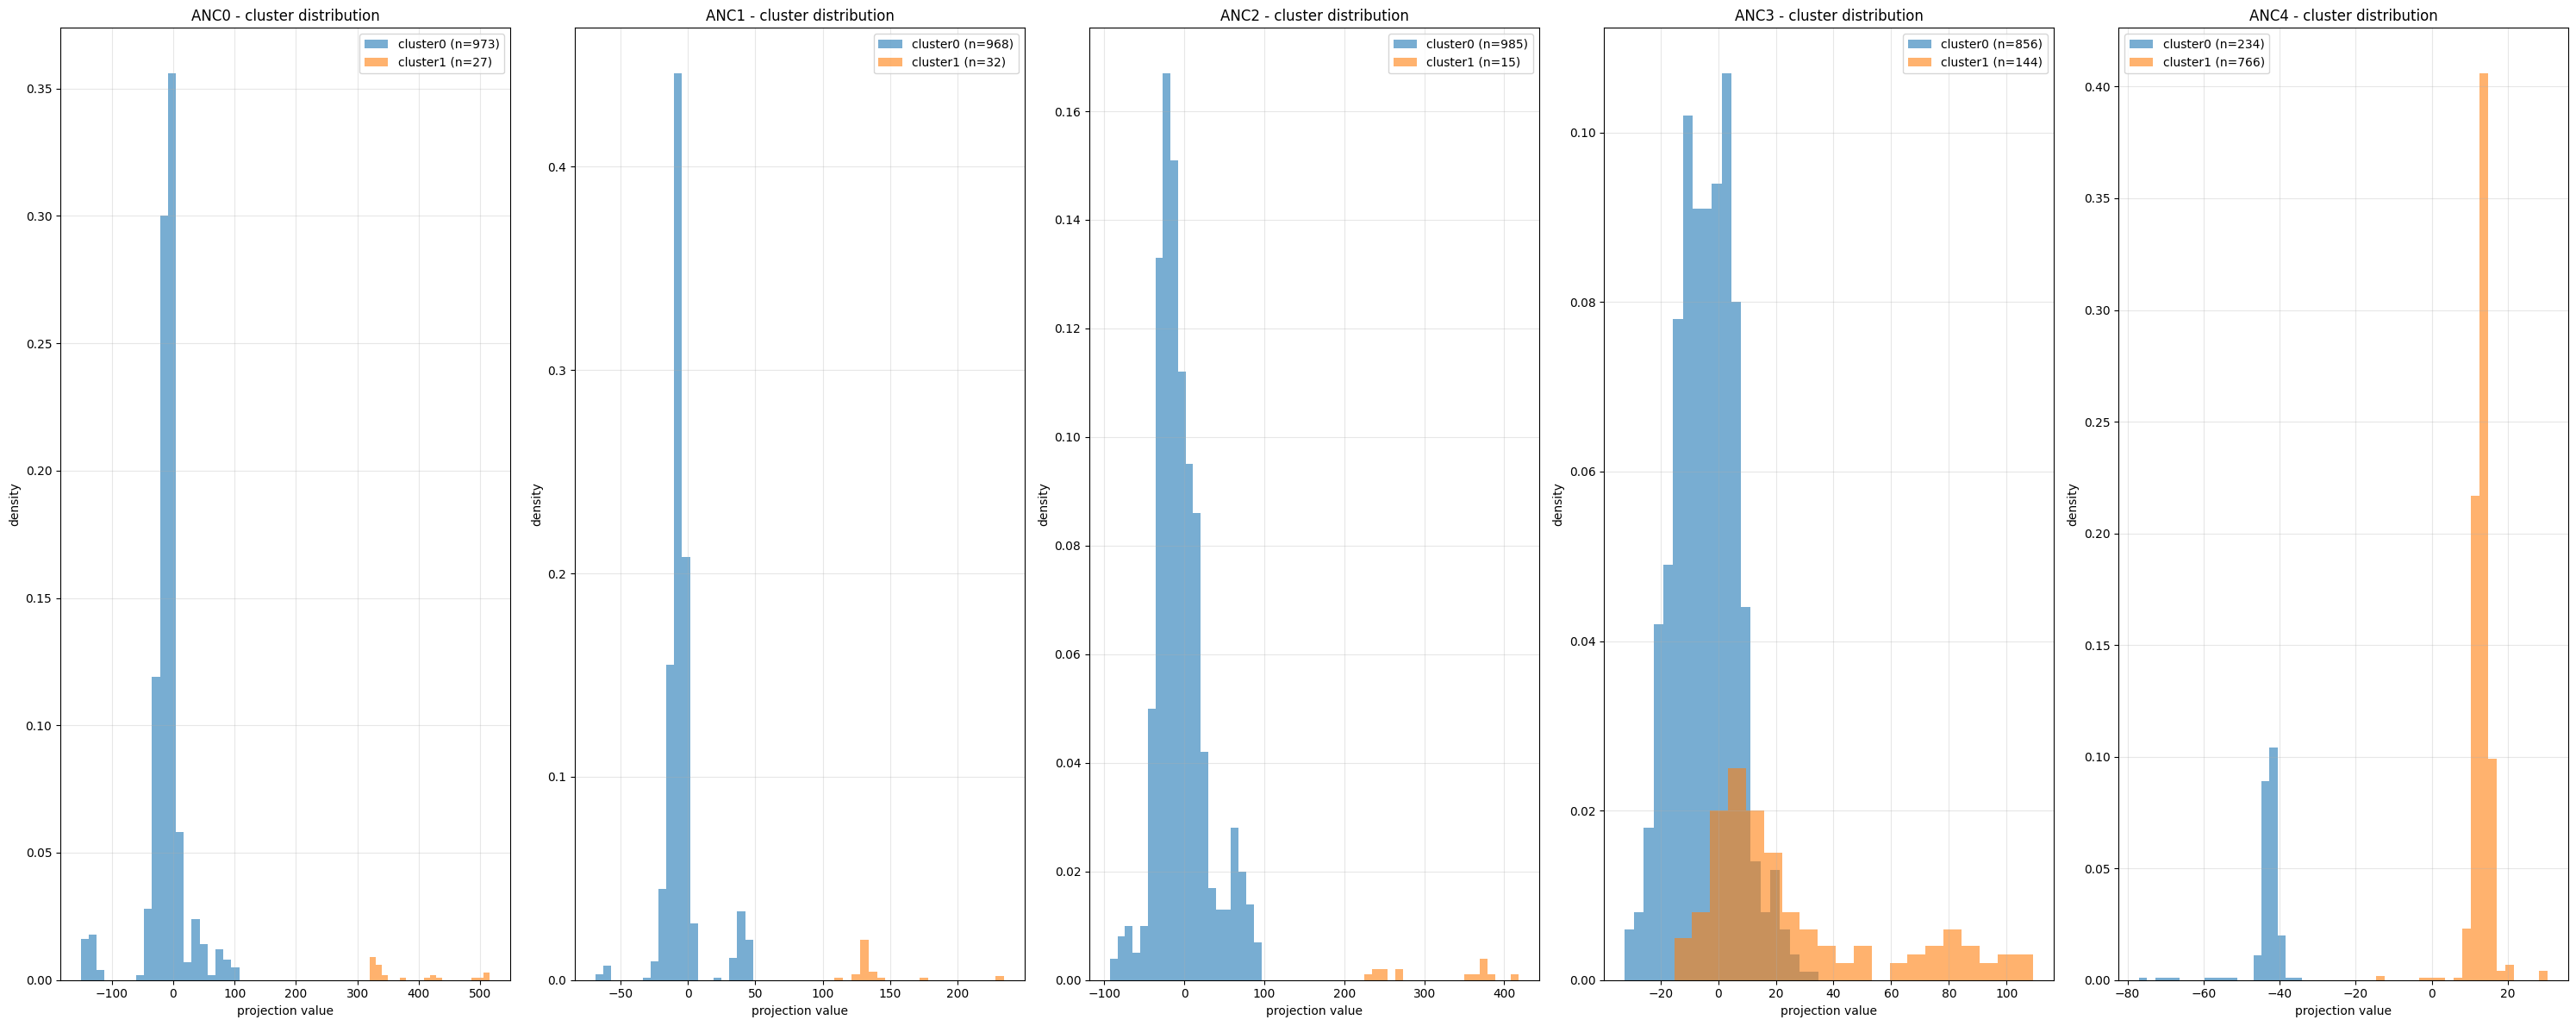

In [5]:
anc0_seqs_path = f"/yezhirui/evo_probe/data/sample/node499_anc0_samples.fasta"
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")
anc0_contact_embedding = generate_contact_embedding(anc0_seqs_path, critical_contacts , mj_dict)
print(f"contact_embedding shape: {anc0_contact_embedding.shape}")

anc1_seqs_path = f"/yezhirui/evo_probe/data/sample/node500_anc1_samples.fasta"
anc1_contact_embedding = generate_contact_embedding(anc1_seqs_path, critical_contacts , mj_dict)

anc2_seqs_path = f"/yezhirui/evo_probe/data/sample/node501_anc2_samples.fasta"
anc2_contact_embedding = generate_contact_embedding(anc2_seqs_path, critical_contacts , mj_dict)

anc3_seqs_path = f"/yezhirui/evo_probe/data/sample/node502_anc3_samples.fasta"
anc3_contact_embedding = generate_contact_embedding(anc3_seqs_path, critical_contacts , mj_dict)

anc4_seqs_path = f"/yezhirui/evo_probe/data/sample/node507_anc4_samples.fasta"
anc4_contact_embedding = generate_contact_embedding(anc4_seqs_path, critical_contacts , mj_dict)


# # 分析anc0数据
# print("=== ANC0 GMM分析 ===")
# k_vals, bic_scores,  best_k = gmm_bic_analysis(anc0_contact_embedding, max_k=5, verbose=True)

# # 绘制BIC曲线
# plot_bic_curve(k_vals, bic_scores, "ANC0 GMM BIC score curve")


# # 使用最优k值进行聚类
# gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc0_contact_embedding, 2)
# print(f"GMM聚类结果: {len(np.unique(gmm_labels))}个聚类")
# print(f"各聚类大小: {np.bincount(gmm_labels)}")


datasets = {
    'ANC0': anc0_contact_embedding,
    'ANC1': anc1_contact_embedding,
    'ANC2': anc2_contact_embedding,
    'ANC3': anc3_contact_embedding,
    'ANC4': anc4_contact_embedding
}

all_results = compare_gmm_guided_projections(
    datasets,
    k=2,
    figsize=(30, 12)
)

  

In [ ]:
anc2_results = all_results['ANC2']
anc3_results = all_results['ANC3']
anc4_results = all_results['ANC4']

top_k = 10

print("======ANC2=======")
anc2_V = anc2_results['projection_vector']
top_indices = np.argsort(anc2_V)[-top_k:][::-1]
# print(f"top_indices: {top_indices}")
critical_contacts_array = np.array(critical_contacts)
print(critical_contacts_array[top_indices])

print("======ANC3=======")
anc3_V = anc3_results['projection_vector']
top_indices = np.argsort(anc3_V)[-top_k:][::-1]
# print(f"top_indices: {top_indices}")
critical_contacts_array = np.array(critical_contacts)
print(critical_contacts_array[top_indices])

print("======ANC4=======")
anc4_V = anc4_results['projection_vector']
top_indices = np.argsort(anc4_V)[-top_k:][::-1]
# print(f"top_indices: {top_indices}")
critical_contacts_array = np.array(critical_contacts)
print(critical_contacts_array[top_indices])


def get_sequences_by_label(gmm_labels, label_id, sequences):
    """
    根据GMM标签提取对应的序列
    
    Args:
        gmm_labels: GMM聚类标签数组
        label_id: 目标标签ID
        sequences: 序列列表
        
    Returns:
        filtered_sequences: 符合标签的序列列表
    """
    mask = gmm_labels == label_id
    filtered_sequences = [sequences[i] for i in range(len(sequences)) if mask[i]]
    return filtered_sequences



label_1_sequences = get_sequences_by_label(anc2_results['labels'], 1, sequences)
print(f"标签1的序列数量: {len(label_1_sequences)}")








======ANC2=======
[[16 49]
 [16 48]
 [16 43]
 [16 47]
 [19 43]
 [16 44]
 [15 43]
 [33 57]
 [33 58]
 [19 42]]
======ANC3=======
[[14 45]
 [11 45]
 [ 8 45]
 [24 45]
 [12 45]
 [38 45]
 [17 45]
 [13 45]
 [15 45]
 [25 45]]
======ANC4=======
[[49 60]
 [36 60]
 [39 60]
 [21 60]
 [37 60]
 [51 60]
 [32 60]
 [31 60]
 [27 60]
 [53 60]]


均值向量μ形状: (1, 244)
协方差矩阵Σ形状: (1, 244, 244)
混合权重π形状: (1,)

--- 组件 0 (权重: 1.0000) ---
=== 协方差矩阵主成分分析 ===
协方差矩阵形状: (244, 244)
协方差矩阵行列式: 0.000000e+00
协方差矩阵迹: 241.000244

前10个主成分:
PC	特征值		解释方差	累积方差
--------------------------------------------------
1	12.775941	0.0530		0.0530
2	11.995493	0.0498		0.1028
3	10.316297	0.0428		0.1456
4	9.358109	0.0388		0.1844
5	9.027755	0.0375		0.2219
6	8.806906	0.0365		0.2584
7	8.284371	0.0344		0.2928
8	7.853265	0.0326		0.3254
9	7.335774	0.0304		0.3558
10	7.131691	0.0296		0.3854
第1主成分分析结果:
  特征值: 12.775941
  特征向量模长: 1.000000
  解释方差比例: 0.0530 (5.30%)

第一主成分 v_anc2_pc1_0 特征向量:
  形状: (244,)
  前10个元素: [ 0.0115346   0.00680125 -0.01475735 -0.01440865 -0.00029346  0.01456018
  0.00955783  0.02278815  0.03091593  0.02281441]
  模长验证: 1.000000


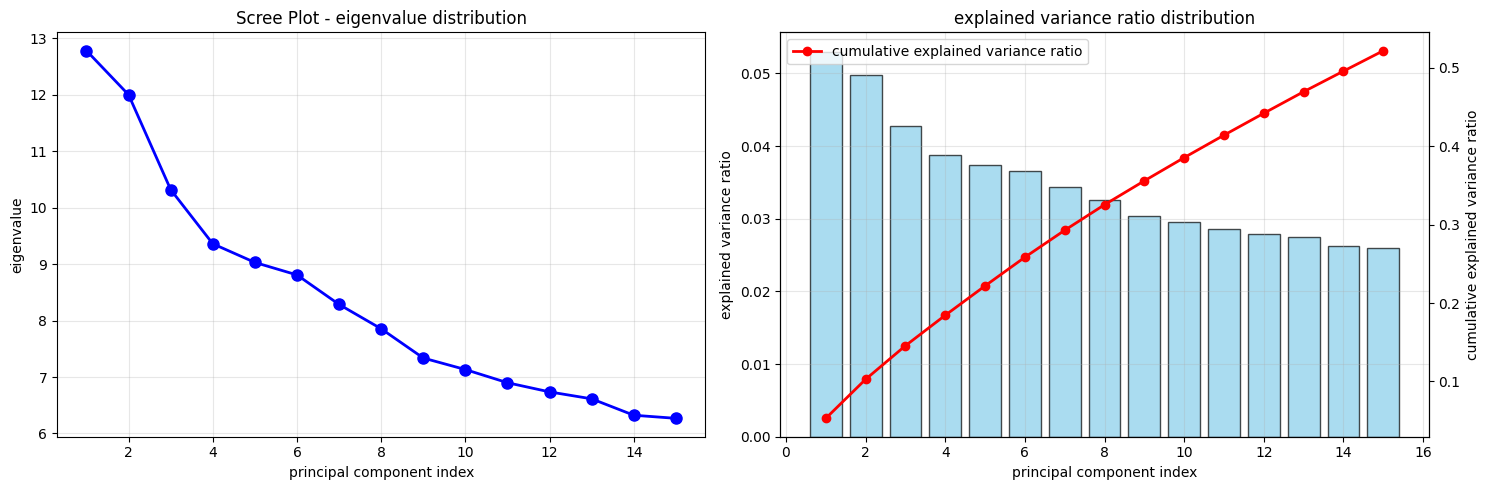


主导组件: 组件0 (权重: 1.0000)
第1主成分分析结果:
  特征值: 12.775941
  特征向量模长: 1.000000
  解释方差比例: 0.0530 (5.30%)

=== 最终结果: ANC2第一主成分 ===
来源: 组件0
特征值λ₁: 12.775941
解释方差比例: 0.0530 (5.30%)
特征向量v_anc2_pc1形状: (244,)
特征向量模长: 1.000000


In [15]:
def extract_gmm_parameters(gmm_model):
    # 提取均值向量μ
    means = gmm_model.means_
    
    # 提取协方差矩阵Σ
    covariances = gmm_model.covariances_
    
    # 提取混合权重π
    weights = gmm_model.weights_
    
    print(f"均值向量μ形状: {means.shape}")
    print(f"协方差矩阵Σ形状: {covariances.shape}")
    print(f"混合权重π形状: {weights.shape}")
    
    return means, covariances, weights

gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc2_contact_embedding, 1)
anc2_means, anc2_covariances, anc2_weights = extract_gmm_parameters(gmm_model)


for component_idx in range(len(anc2_weights)):
    print(f"\n--- 组件 {component_idx} (权重: {anc2_weights[component_idx]:.4f}) ---")
    
    # 获取该组件的协方差矩阵
    sigma_i = anc2_covariances[component_idx]
    
    # 完整PCA分析
    eigenvalues, eigenvectors, explained_ratios = analyze_covariance_pca(sigma_i, top_k=10)
    
    # 提取第一主成分
    lambda_pc1, v_anc2_pc1, var_ratio_pc1 = extract_principal_component_from_covariance(sigma_i, component_idx=0)
    
    print(f"\n第一主成分 v_anc2_pc1_{component_idx} 特征向量:")
    print(f"  形状: {v_anc2_pc1.shape}")
    print(f"  前10个元素: {v_anc2_pc1[:10]}")
    print(f"  模长验证: {np.linalg.norm(v_anc2_pc1):.6f}")
    
    # 可视化
    visualize_principal_components(eigenvalues, explained_ratios, top_k=15)
    
    # 保存结果到全局变量
    if component_idx == 0:
        v_anc2_pc1_component0 = v_anc2_pc1.copy()
    elif component_idx == 1:
        v_anc2_pc1_component1 = v_anc2_pc1.copy()

# 分析哪个组件更重要（权重更大）
dominant_component = np.argmax(anc2_weights)
print(f"\n主导组件: 组件{dominant_component} (权重: {anc2_weights[dominant_component]:.4f})")

# 使用主导组件的第一主成分作为最终结果
final_sigma = anc2_covariances[dominant_component]
lambda_final, v_anc2_pc1_final, var_ratio_final = extract_principal_component_from_covariance(final_sigma, component_idx=0)

print(f"\n=== 最终结果: ANC2第一主成分 ===")
print(f"来源: 组件{dominant_component}")
print(f"特征值λ₁: {lambda_final:.6f}")
print(f"解释方差比例: {var_ratio_final:.4f} ({var_ratio_final*100:.2f}%)")
print(f"特征向量v_anc2_pc1形状: {v_anc2_pc1_final.shape}")
print(f"特征向量模长: {np.linalg.norm(v_anc2_pc1_final):.6f}")

# 将结果赋值给你要求的变量名
v_anc2_pc1 = v_anc2_pc1_final.copy()



均值向量μ形状: (1, 244)
协方差矩阵Σ形状: (1, 244, 244)
混合权重π形状: (1,)

--- 组件 0 (权重: 1.0000) ---
=== 协方差矩阵主成分分析 ===
协方差矩阵形状: (244, 244)
协方差矩阵行列式: 0.000000e+00
协方差矩阵迹: 216.000244

前10个主成分:
PC	特征值		解释方差	累积方差
--------------------------------------------------
1	13.051180	0.0604		0.0604
2	11.329828	0.0525		0.1129
3	10.714274	0.0496		0.1625
4	10.011623	0.0464		0.2088
5	9.318704	0.0431		0.2520
6	8.774249	0.0406		0.2926
7	8.473755	0.0392		0.3318
8	8.181647	0.0379		0.3697
9	7.733862	0.0358		0.4055
10	7.539418	0.0349		0.4404
第1主成分分析结果:
  特征值: 13.051180
  特征向量模长: 1.000000
  解释方差比例: 0.0604 (6.04%)

第一主成分 v_anc1_pc1_0 特征向量:
  形状: (244,)
  前10个元素: [ 2.50432256e-02 -7.48074384e-03 -1.66533454e-16  3.33066907e-16
 -1.11022302e-16  1.74131770e-03  2.77663165e-02  3.81987824e-02
  3.29945997e-02  3.02885804e-02]
  模长验证: 1.000000


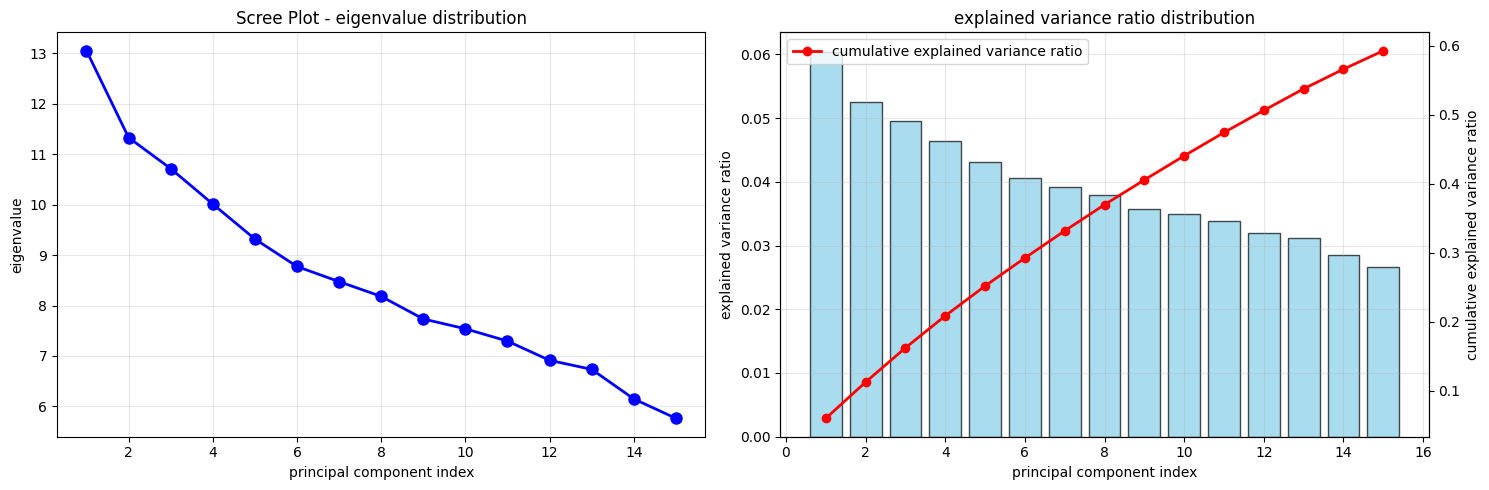


主导组件: 组件0 (权重: 1.0000)
第1主成分分析结果:
  特征值: 13.051180
  特征向量模长: 1.000000
  解释方差比例: 0.0604 (6.04%)

=== 最终结果: anc1第一主成分 ===
来源: 组件0
特征值λ₁: 13.051180
解释方差比例: 0.0604 (6.04%)
特征向量v_anc1_pc1形状: (244,)
特征向量模长: 1.000000


In [23]:
gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc1_contact_embedding, 1)
anc1_means, anc1_covariances, anc1_weights = extract_gmm_parameters(gmm_model)


for component_idx in range(len(anc1_weights)):
    print(f"\n--- 组件 {component_idx} (权重: {anc1_weights[component_idx]:.4f}) ---")
    
    # 获取该组件的协方差矩阵
    sigma_i = anc1_covariances[component_idx]
    
    # 完整PCA分析
    eigenvalues, eigenvectors, explained_ratios = analyze_covariance_pca(sigma_i, top_k=10)
    
    # 提取第一主成分
    lambda_pc1, v_anc1_pc1, var_ratio_pc1 = extract_principal_component_from_covariance(sigma_i, component_idx=0)
    
    print(f"\n第一主成分 v_anc1_pc1_{component_idx} 特征向量:")
    print(f"  形状: {v_anc1_pc1.shape}")
    print(f"  前10个元素: {v_anc1_pc1[:10]}")
    print(f"  模长验证: {np.linalg.norm(v_anc1_pc1):.6f}")
    
    # 可视化
    visualize_principal_components(eigenvalues, explained_ratios, top_k=15)
    
    # 保存结果到全局变量
    if component_idx == 0:
        v_anc1_pc1_component0 = v_anc1_pc1.copy()
    elif component_idx == 1:
        v_anc1_pc1_component1 = v_anc1_pc1.copy()

# 分析哪个组件更重要（权重更大）
dominant_component = np.argmax(anc1_weights)
print(f"\n主导组件: 组件{dominant_component} (权重: {anc1_weights[dominant_component]:.4f})")

# 使用主导组件的第一主成分作为最终结果
final_sigma = anc1_covariances[dominant_component]
lambda_final, v_anc1_pc1_final, var_ratio_final = extract_principal_component_from_covariance(final_sigma, component_idx=0)

print(f"\n=== 最终结果: anc1第一主成分 ===")
print(f"来源: 组件{dominant_component}")
print(f"特征值λ₁: {lambda_final:.6f}")
print(f"解释方差比例: {var_ratio_final:.4f} ({var_ratio_final*100:.2f}%)")
print(f"特征向量v_anc1_pc1形状: {v_anc1_pc1_final.shape}")
print(f"特征向量模长: {np.linalg.norm(v_anc1_pc1_final):.6f}")

# 将结果赋值给你要求的变量名
v_anc1_pc1 = v_anc1_pc1_final.copy()



0.666944800453637
PC1 explained variance ratio: 0.053
PC1 feature vector shape: (244,)


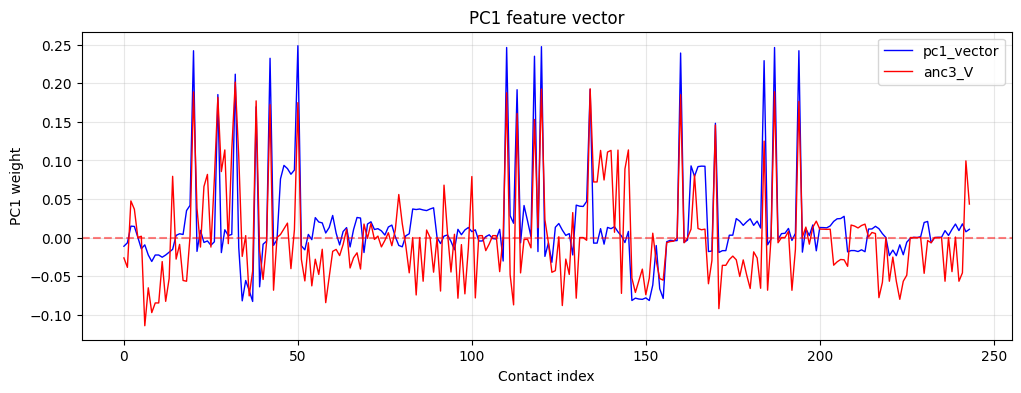

In [28]:
# 简单PCA降维
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = anc2_contact_embedding

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 获取PC1特征向量
pc1_vector = pca.components_[0]

anc3_V_normalized = anc3_V / np.linalg.norm(anc3_V)

cosine_similarity = np.dot(pc1_vector, anc3_V_normalized) / (np.linalg.norm(pc1_vector) * np.linalg.norm(anc3_V_normalized))
print(cosine_similarity)

print(f"PC1 explained variance ratio: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC1 feature vector shape: {pc1_vector.shape}")

# 绘制PC1特征向量
plt.figure(figsize=(12, 4))
plt.plot(range(len(pc1_vector)), pc1_vector, 'b-', linewidth=1, label='pc1_vector')
plt.plot(range(len(anc3_V_normalized)), anc3_V_normalized, 'r-', linewidth=1, label='anc3_V')

plt.xlabel('Contact index')
plt.ylabel('PC1 weight')
plt.title('PC1 feature vector')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.show()